In [1]:
import numpy as np
import healpy as hp
import pebbles
import matplotlib.pyplot as plt
import pymaster as nmt
plt.style.use('blt_paper')

In [2]:
def sigma_amin_to_map_pix(sigma, nside, fsky=1):
    """ Function to calculate the power spectrum for a given instrument
    sensitivity in uK_amin.

    Parameters
    ----------
    sigma: float
        Instrument sensitivity in uKamin.
    nside: int
        Resolution parameter, determines length of output cell array.

    Returns
    -------
    ndarray
        Array containing the white noise power spectrum.

    Notes
    -----
    We apply the simple formula (e.g. Tegmark 1997)
    
    ..math::
        C_\ell^{\rm noise} = \Omega \frac{\sigma^2_{\rm pix}}{N_{\rm pix}}

    where $\Omega$ is the sky fraction of the survey ($f_{\rm sky} 4 \pi$).
    """
    # calculate the number square arcminutes in full sky
    amin2 = 4. * np.pi * (10800./ np.pi) ** 2
    # number of pixels
    npix = hp.nside2npix(nside)
    # calculate the sigma_pix
    sigma_pix_p = np.sqrt(sigma ** 2 / amin2 * npix)
    sigma_pix_t = sigma_pix_p / np.sqrt(2.)
    np.random.seed(None)
    random_var = np.random.randn(3 * npix).reshape((3, -1))
    random_var[0, :] *= sigma_pix_t
    random_var[1:, :] *= sigma_pix_p
    return random_var

def sigma_amin_to_cell(sigma, nside, fsky=1.):
    """ Function to calculate the power spectrum for a given instrument
    sensitivity in uK_amin.

    Parameters
    ----------
    sigma: float
        Instrument sensitivity in uKamin.
    nside: int
        Resolution parameter, determines length of output cell array.

    Returns
    -------
    ndarray
        Array containing the white noise power spectrum.

    Notes
    -----
    We apply the simple formula (e.g. Tegmark 1997)
    
    ..math::
        C_\ell^{\rm noise} = \Omega \frac{\sigma^2_{\rm pix}}{N_{\rm pix}}

    where $\Omega$ is the sky fraction of the survey ($f_{\rm sky} 4 \pi$).
    """
    # calculate the number square arcminutes in full sky
    amin2 = 4. * np.pi * (10800./ np.pi) ** 2
    # calculate white noise power spectrum on whole sky
    wn_ps = 4. * np.pi * sigma ** 2 / amin2
    # rescale to sky fraction actually observerd
    wn_ps *= fsky
    #return as array
    return wn_ps * np.ones(3 * nside)

def sigma_amin_to_map_ps(sigma, nside):
    """ Function to generate white noise maps for a list of pixel noise levels and
    a given resolution. 

    Parameters
    ----------
    sigmas: list(float)
        List of pixel noise levels, in uKamin.
    nside: int
        Resolution parameter of the maps to which these resolutions correspond.

    Returns
    -------
    list(array_like(float)), list(array_like(float))
        List of noise maps, and list of the corresponding variance maps.

    Notes
    -----
    Assuming white noise, the pixel noise levels given in uKamin can be
    converted to a noice map. We first calculate the noise power spectrum
    according to Knox 1995:

    ..math::
        N_\ell = 4 \pi \frac{\sigma_{\rm amin}^2}{4 \pi (\frac{10800}{\pi})^2}

    We then make a realization of this power spectrum and return it, along
    with a variance map. We calculate the pixel variance as:

    ..math::
       \sigma^2_{\rm pix} / N_{\rm pix} = \sigma^2_{\rm amin} / (4\pi\frac{10800}{\pi})^2
    """
    n_p = sigma_amin_to_cell(sigma, nside) 
    n_t = sigma_amin_to_cell(sigma / np.sqrt(2.), nside) 
    noise_cls = np.array([n_t, n_p, n_p, np.zeros_like(n_p)])
    np.random.seed(None)
    noise = hp.synfast(noise_cls, nside, new=True, pol=True, verbose=False)
    return np.array(noise)

In [3]:
sigma_amin = 4
nside = 128
npix = hp.nside2npix(nside)
amin2 = 4. * np.pi * (10800. / np.pi) ** 2 

theory_cl = sigma_amin_to_cell(sigma_amin, nside)

pix_method = {}
pix_method.update({'noise_map': sigma_amin_to_map_pix(sigma_amin, nside)})
pix_method.update({'pix_var': np.std(pix_method['noise_map'], axis=-1) * np.sqrt(amin2 / npix)})
pix_method.update({'cls': hp.anafast(pix_method['noise_map'], pol=True)})

In [4]:
ps_method = {}
ps_method.update({'noise_map': sigma_amin_to_map_ps(sigma_amin, nside)})
ps_method.update({'pix_var': np.std(ps_method['noise_map'], axis=-1) * np.sqrt(amin2 / npix)})
ps_method.update({'cls': hp.anafast(ps_method['noise_map'], pol=True)})

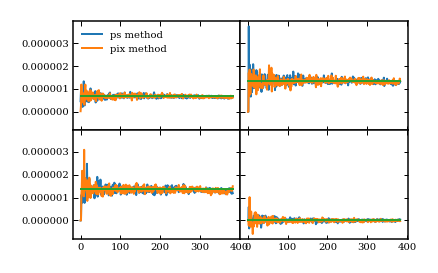

In [5]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
axes[0, 0].plot(ps_method['cls'][0], label='ps method')
axes[0, 0].plot(pix_method['cls'][0], label='pix method')
axes[0, 0].plot(theory_cl / 2.)
axes[0, 1].plot(ps_method['cls'][1])
axes[0, 1].plot(pix_method['cls'][1])
axes[1, 0].plot(ps_method['cls'][2])
axes[1, 0].plot(pix_method['cls'][2])
axes[1, 1].plot(ps_method['cls'][3])
axes[1, 1].plot(pix_method['cls'][3])
axes[1, 1].plot(0. * theory_cl)
axes[0, 1].plot(theory_cl)
axes[1, 0].plot(theory_cl)
axes[0, 0].legend()
plt.show()

In [6]:
print(ps_method['pix_var'])
print(pix_method['pix_var'])
print((pix_method['pix_var'] / ps_method['pix_var']) ** 2)

[2.43873415 3.47434411 3.47007093]
[2.83066798 3.98116023 4.00101246]
[1.34725234 1.31302699 1.32942274]


In [7]:
resynth = hp.synfast(pix_method['cls'], nside, new=True, pol=True)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


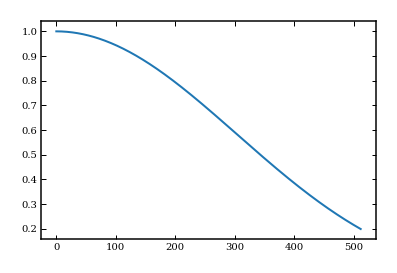

In [8]:
plt.plot(hp.sphtfunc.pixwin(nside) ** 2)

In [9]:
print(pix_method['noise_map'].shape)
print(ps_method['noise_map'].shape)

(3, 196608)
(3, 196608)


In [10]:
a = np.array([sigma_amin_to_map_ps(sigma_amin, nside) for _ in range(100)])

In [11]:
np.mean(np.sqrt(np.var(a, axis=0) * amin2 / npix), axis=-1)

array([2.43142877, 3.4378386 , 3.43832161])

In [12]:
pix_method['cls']

array([[ 2.38609858e-08,  2.55220643e-07,  1.18757409e-06, ...,
         6.52940104e-07,  6.31669939e-07,  6.15074781e-07],
       [ 0.00000000e+00,  0.00000000e+00,  1.70240370e-06, ...,
         1.33450731e-06,  1.44999963e-06,  1.35107402e-06],
       [ 0.00000000e+00,  0.00000000e+00,  1.11366262e-06, ...,
         1.29065895e-06,  1.34070484e-06,  1.49316168e-06],
       [ 0.00000000e+00,  0.00000000e+00, -2.19225694e-07, ...,
        -1.51067300e-08,  1.30969909e-08, -2.37051378e-08],
       [ 0.00000000e+00,  0.00000000e+00,  2.24678778e-07, ...,
        -3.86855866e-08, -1.06753463e-07,  9.73178703e-08],
       [ 0.00000000e+00,  0.00000000e+00, -8.91484726e-07, ...,
         5.00628699e-08,  4.05020579e-09, -1.37008839e-08]])

In [13]:
ps_method['cls']

array([[ 4.60072670e-07,  8.89744549e-07,  4.62798261e-07, ...,
         6.26654002e-07,  6.50266919e-07,  6.43921613e-07],
       [ 0.00000000e+00,  0.00000000e+00,  3.72200717e-06, ...,
         1.30426449e-06,  1.26043565e-06,  1.30608341e-06],
       [ 0.00000000e+00,  0.00000000e+00,  1.11259870e-06, ...,
         1.30175748e-06,  1.24851414e-06,  1.18874323e-06],
       [ 0.00000000e+00,  0.00000000e+00,  5.90727242e-07, ...,
        -1.64963401e-09,  6.79707406e-09,  4.25489506e-08],
       [ 0.00000000e+00,  0.00000000e+00,  8.87342505e-07, ...,
         2.21013256e-08, -3.41209127e-08,  3.06002183e-08],
       [ 0.00000000e+00,  0.00000000e+00,  3.56711198e-07, ...,
         2.99199120e-08, -6.50297277e-10,  4.14036204e-09]])

# Comparing white and non-white noise

We now compare the SO V3 noise calculator to the white noise calculation above. The V3 calculator includes non-white noise contributions from the atmosphere. This term modifies a white noise term, which is given by the white noise levels used in the white noise-only version. Therefore, we would expect the two methods to agree at high multipoles, and for there to be excess noise at low multipoles in the case of the V3 calculator. 

We calculate the power spectrum for the lowest frequency channel (27 GHz), which has a white noise level of 32.3 $\mu {\rm Kamin}$. 


In [14]:
channel = 0
nside = 256

In [15]:
# first get the V3 calculator map
v3_noise_map, v3_ivar_map = pebbles.pebbles.get_noise_sim(nside_out=nside)
v3_noise_map = v3_noise_map[channel, 1:]
v3_ivar_map = v3_ivar_map[channel]

white noise level:  [32.26948162 21.51298775  2.43392281  2.73816316  5.48392705 13.46929451] [uK-arcmin]


In [16]:
# and then the white noise map. Check that the noise level is the same as that stated by the V3 calculator.
noise_levels = pebbles.configurations.ins['sofidV3_wn_smo']['noise_params']['sigmas'] 
print("White noise level: ", noise_levels[channel])
# get the hits map used to rescale the V3 calculator noise realization. 
nh = pebbles.pebbles.get_nhits(nside)
nh[np.where(nh < 1e-6)[0]] = np.amax(nh)
hits_scaling = np.sqrt(nh / np.amax(nh))
# select just the Q and U maps and rescale by the hits map
wn_noise_map = pebbles.pebbles.sigma_amin_p_to_maps(noise_levels[channel], nside)[1:] / hits_scaling

White noise level:  32.3


In [17]:
# get the mask defining the SO observation region. The fsky = <M> = 0.1 for this map.
mask = pebbles.pebbles.get_mask(nside)

In [18]:
# calculate EE and BB spectra of the noise realizations on this mask 
wn_field = nmt.NmtField(mask, wn_noise_map)
v3_field = nmt.NmtField(mask, v3_noise_map)

In [19]:
nmtbin = nmt.NmtBin(nside, nlb=5)
ells = nmtbin.get_effective_ells()
wn_cls = nmt.compute_full_master(wn_field, wn_field, nmtbin)
v3_cls = nmt.compute_full_master(v3_field, v3_field, nmtbin)

In [20]:
# get the theoretical noise curve from the v3 calculator and the white noise realization
# v3 calculator
sensitivity = 2
knee_mode = 2
ny_lf = 1.
fsky = np.mean(mask)
_, nll_v3, sigma_amin = pebbles.V3calc.so_V3_SA_noise(sensitivity, knee_mode, ny_lf, fsky, 3*nside, remove_kluge=True)
# white noise
nll_wn = pebbles.pebbles.sigma_amin_to_cell(noise_levels[channel], nside)

white noise level:  [32.26948162 21.51298775  2.43392281  2.73816316  5.48392705 13.46929451] [uK-arcmin]


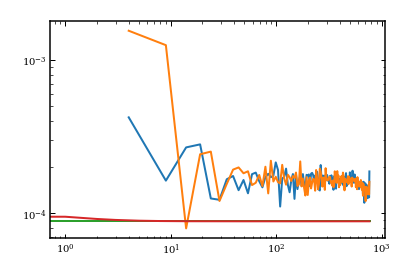

In [21]:
fig, ax1 = plt.subplots(1, 1)
ax1.loglog(ells, wn_cls[0])
ax1.loglog(ells, v3_cls[0])
ax1.loglog(nll_wn)
ax1.loglog(nll_v3[channel])

The excess over the theoretical lines is entirely due to multiplying by the hits scaling. The hits scaling is between 0 and 1, and we divide the noise map by it, so it has the average effect of increasing the overall variance.

This is not taken into account in power spectrum space, but it is refelcted in the inverse-variance map. Next we check that the variance of many noise realizations agrees with the inverse variances maps.

In [69]:
nside = 16
nmc = 5000
channel = 3

In [70]:
v3_maps = []
for _ in range(nmc):
    v3_noise_map, v3_var_map = pebbles.pebbles.get_noise_sim(nside_out=nside)
    v3_maps.append(v3_noise_map[channel, 1:])

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  

white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]
white noise level:  [32.41273368 21.60848912  2.44472758  2.75031853  5.50827154 13.52908798] [uK-arcmin]


In [71]:
ivar_v3_dat = 1. / np.var(np.array(v3_maps), axis=0)[0]
ivar_v3_the = 1. / v3_var_map[channel, 0]
print(ivar_v3_dat)
print(ivar_v3_the)

[1.20280628e+01 3.36073578e-01 3.74936614e+01 ... 4.59050544e+02
 6.20170072e+02 8.09736596e+02]
[3.85635222e+01 1.11147824e+00 1.24183824e+02 ... 1.53650749e+03
 2.09976759e+03 2.64656946e+03]


In [72]:
mask = pebbles.pebbles.get_mask(nside)
md = lambda d: np.ma.masked_array(mask=(mask < 1e-6), data=d, fill_value=hp.UNSEEN)

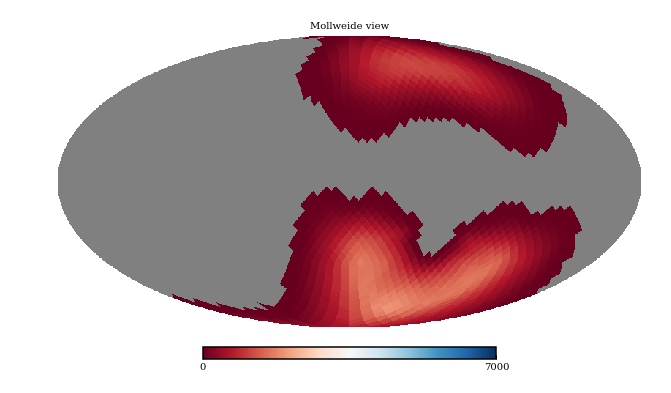

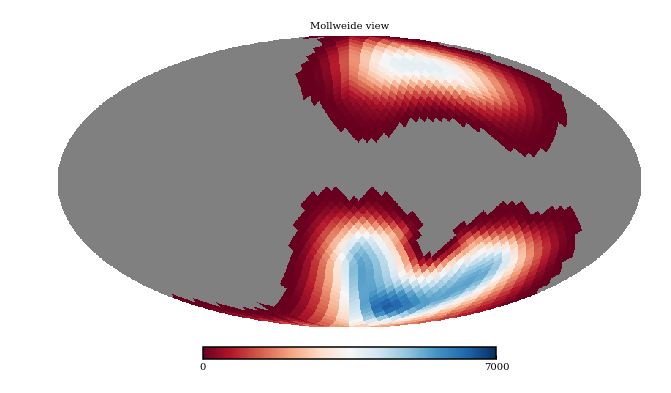

In [76]:
hp.mollview(md(ivar_v3_dat), min=0, max=7000)
hp.mollview(md(ivar_v3_the), min=0, max=7000)

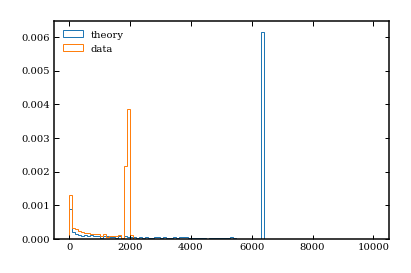

In [77]:
fig, ax = plt.subplots(1, 1)
ax.hist(md(ivar_v3_the).data, range=(0, 10000), histtype='step', label='theory', density=True, bins=100)
ax.hist(md(ivar_v3_dat).data, range=(0, 10000), histtype='step', label='data', density=True, bins=100)
ax.legend()

In [ ]:
hp.mollview(md((1./ivar_v3_the - 1./ivar_v3_dat)*ivar_v3_the))

In [ ]:
v3_noise_map, v3_var_map = pebbles.pebbles.get_noise_sim(nside_out=512)


In [ ]:
mask_512 = pebbles.pebbles.get_mask(512)
md_512 = lambda d: np.ma.masked_array(mask=(mask_512 < 1e-6), data=d * mask_512, fill_value=hp.UNSEEN)

In [ ]:
hp.mollview(md_512(v3_noise_map[3][1]), coord=['G', 'C'])

In [ ]:
gmap = hp.read_map("pebbles/data/hit/norm_nHits_SA_35FOV.fits")

In [ ]:
hp.mollview(gmap)